In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

from matplotlib import pyplot as plt

from data_handler import TrainDataHandler

TRAIN_VARIANTS_PATH = "../data/training_variants/training_variants"
TRAIN_TEXT_PATH = "../data/training_text/training_text"


# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

In [2]:
train_data_handler = TrainDataHandler(TRAIN_VARIANTS_PATH, TRAIN_TEXT_PATH)

2022-12-18 22:30:25 | DEBUG    | data_handler         | Loading the train variants data..
2022-12-18 22:30:25 | DEBUG    | data_handler         | Loading the train text data..
2022-12-18 22:30:27 | DEBUG    | data_handler         | Preparing train data ..
2022-12-18 22:30:27 | INFO     | data_handler         | Train data is loaded. (Data size: (3316, 5))


In [3]:
train_data = train_data_handler.train_data.copy()
train_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
def my_precision_score(y_true, y_pred):
    return precision_score(y_true, y_pred, average="weighted")


def my_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, average="weighted")

In [5]:
EVAL_METRIC_DICT = {
    "accuracy_score": accuracy_score,
    "balanced_accuracy_score": balanced_accuracy_score,
    "precision_score": my_precision_score,
    "recall_score": my_recall_score,
}

In [6]:
# use NLP to classify the text deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tf.keras.metrics.binary_accuracy

# ensure that code uses GPU
print(tf.test.gpu_device_name())

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train_data['Text'], train_data['Class'], test_size=0.2,
                                                            random_state=0)

# vectorize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_enc = tokenizer.texts_to_sequences(X_train)
X_test_enc = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train_enc = pad_sequences(X_train_enc, padding='post', maxlen=maxlen)
X_test_enc = pad_sequences(X_test_enc, padding='post', maxlen=maxlen)

# train the model
embedding_dim = 50

model = keras.Sequential()
model.add(layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=maxlen)
)
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("Model summary: ", model.summary())

history = model.fit(
    X_train_enc, y_train,
    epochs=200,
    verbose=False,
    validation_data=(X_test_enc, y_test)
)

loss, accuracy = model.evaluate(X_train_enc, y_train, verbose=False)
print("Training Accuracy: {:.4f} | Loss: {:.4f}".format(accuracy, loss))
loss, accuracy = model.evaluate(X_test_enc, y_test, verbose=False)
print("Test Accuracy: {:.4f} | Loss: {:.4f}".format(accuracy, loss))

# predict the test data
pred = model.predict(X_test_enc)
pred = np.argmax(pred, axis=1)

print("Accuracy score for classifier: ", accuracy_score(y_test, pred))

/device:GPU:0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           8276050   
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 8,276,670
Trainable params: 8,276,670
Non-trainable params: 0
_________________________________________________________________
Model summary:  None
Training Accuracy: 0.8341 | Loss: 0.3426
Test Accuracy: 0.5527 | Loss: 2.3359

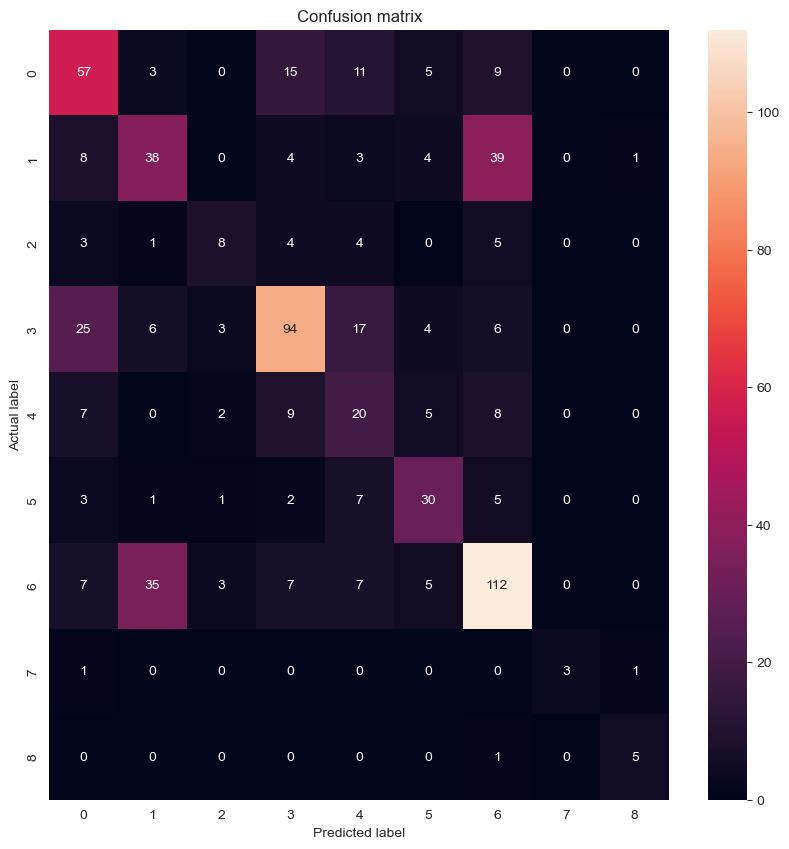

In [7]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)

# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
from exploratory_data_analysis import mapping

final_pred = train_data.loc[X_test.index, :].copy()
final_pred["Prediction"] = pred
final_pred["Prediction_Name"] = final_pred["Prediction"].replace(mapping)

In [24]:
final_pred[final_pred["Gene"] == "TP53"]

,ID,Gene,Variation,Class,Text,Prediction,Prediction_Name
453,453,TP53,H168R,4,The tumor suppressor protein p53 acts as a tra...,5,Likely Neutral
482,482,TP53,G334R,3,Abstract Purpose Adrenocortical carcinoma (A...,4,Loss-of-function
489,489,TP53,R280T,1,p53 mutation is associated with “gain-of-funct...,7,Gain-of-function
410,410,TP53,S121C,6,Tumor suppressor p53-dependent apoptosis is th...,6,Inconclusive
480,480,TP53,DNA binding domain missense mutations,4,Mutations in the p53 tumor suppressor are the ...,1,Likely Loss-of-function
483,483,TP53,V173L,4,The transcription factor and tumor suppressor ...,4,Loss-of-function
405,405,TP53,C242F,1,The tumor suppressor protein p53 is inactivate...,2,Likely Gain-of-function
402,402,TP53,Q331H,1,Mutational hotspots indicate selective pressur...,1,Likely Loss-of-function
472,472,TP53,A347T,1,The tumor suppressor protein p53 is a transcri...,1,Likely Loss-of-function
399,399,TP53,S240R,1,Inheritance of germ-line mutant alleles of BRC...,1,Likely Loss-of-function


In [25]:
final_pred.to_csv("DeepLearningPredictions.csv")